# Supervised Learning Final Project

For the final project, I found a dataset on Kaggle to predict loan default.  The dataset came from Kaggle and included 148,670 rows and 34 columns of data.  The features included factors like gender, age, income, credit_score and several other factors.  

Loan default prediction is a critical problem in the finance industry, directly impacting the profitability and risk management of lending institutions. An accurate prediction model can help institutions make informed decisions on whether to approve a loan, thereby reducing the likelihood of financial loss due to defaults. Given the high stakes involved, it is essential not only to focus on overall accuracy but also to minimize the number of false negatives (incorrectly predicting a borrower will not default). False negatives could lead to risky loans being approved, resulting in significant financial losses.

https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data


# Data Cleaning and EDA

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%matplotlib inline

In [35]:
# Load Data
df = pd.read_csv('loan_default.csv')

In [36]:
# Check Data
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [37]:
# Check data info for data types and potential missing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

Since there is a lot of data in this dataset and appears there are several columns with missing values, I will look for how much data is missing as a percentage of each column and start to fill in the missing data accoringly.

In [38]:
# Function to find percentage of missing data
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum()/len(df)
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    
    return percent_nan

Upfront_charges              26.664425
Interest_rate_spread         24.644515
rate_of_interest             24.509989
dtir1                        16.224524
property_value               10.155378
LTV                          10.155378
income                        6.154571
loan_limit                    2.249277
approv_in_adv                 0.610749
age                           0.134526
submission_of_application     0.134526
loan_purpose                  0.090133
Neg_ammortization             0.081388
term                          0.027578
dtype: float64


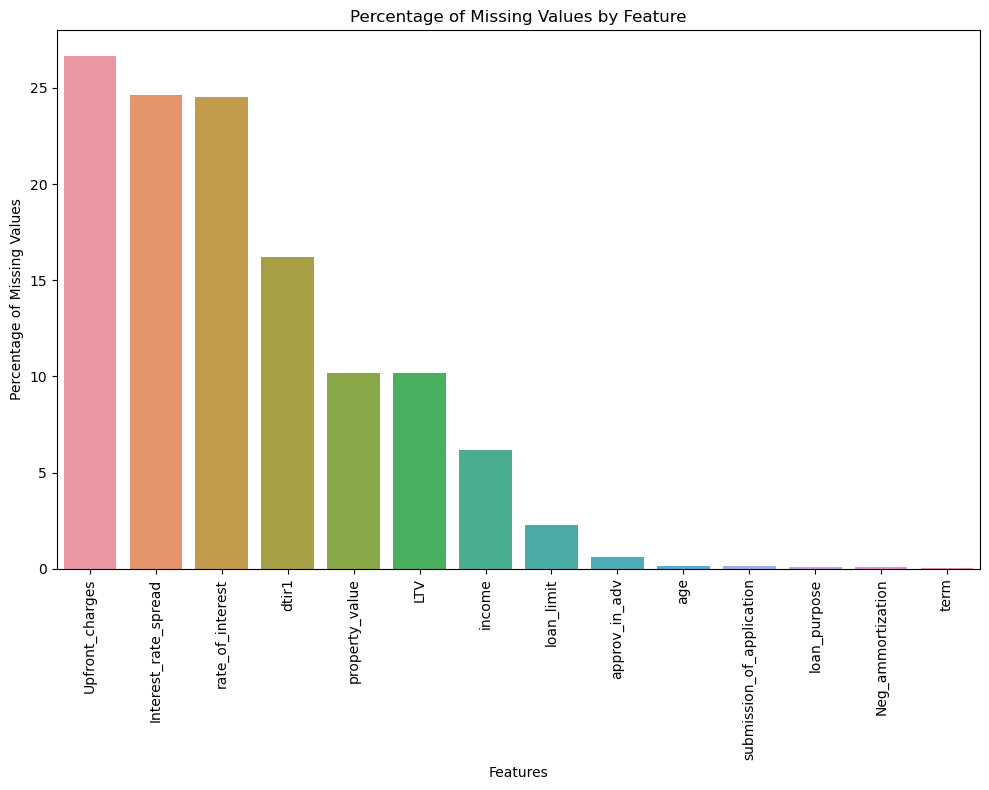

In [39]:
# Calculate the percentage of missing data
percent_nan = percent_missing(df)

# Sort the missing percentages in descending order
percent_nan_sorted = percent_nan.sort_values(ascending=False)

# Print sorted values
print(percent_nan_sorted)

pd.reset_option('display.max_columns')

# Plotting sorted missing values
plt.figure(figsize=(10, 8))
sns.barplot(x=percent_nan_sorted.index, y=percent_nan_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values by Feature')
plt.tight_layout()
plt.show()

For columns with a low percentage of missing values, less than 1%, I will drop the missing values since it shouldn't have much impact on the results.

In [40]:
columns_with_low_na = ['approv_in_adv','age','submission_of_application','loan_purpose','Neg_ammortization','term']
df = df.dropna(subset=columns_with_low_na)

In [41]:
# Re-calculate percentage of missing data
percent_nan = percent_missing(df)

# Sort the missing percentages in descending order
percent_nan_sorted = percent_nan.sort_values(ascending=False)

# Print sorted values
print(percent_nan_sorted)


Upfront_charges         26.655078
rate_of_interest        24.528430
Interest_rate_spread    24.528430
dtir1                   16.129799
property_value          10.160653
LTV                     10.160653
income                   6.055380
loan_limit               2.262450
dtype: float64


With the remaining missing data, I will do some further analysis to determine the best way to handle the missing values.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='rate_of_interest', ylabel='Count'>

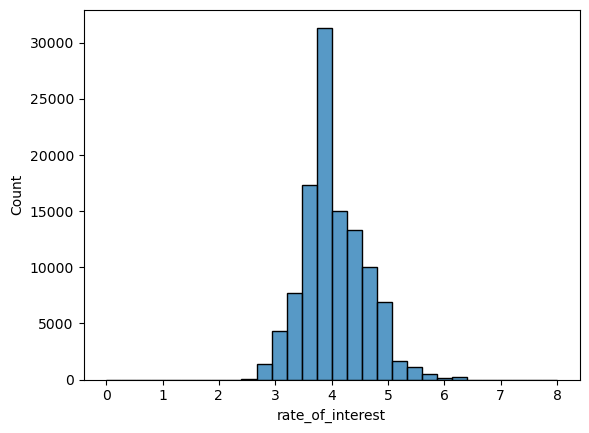

In [42]:
sns.histplot(data=df,x='rate_of_interest',bins=30)

Based on the distribution of the rates I will fill missing values with the mean.

In [43]:
df['rate_of_interest'].fillna(df['rate_of_interest'].mean(), inplace=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Upfront_charges', ylabel='Count'>

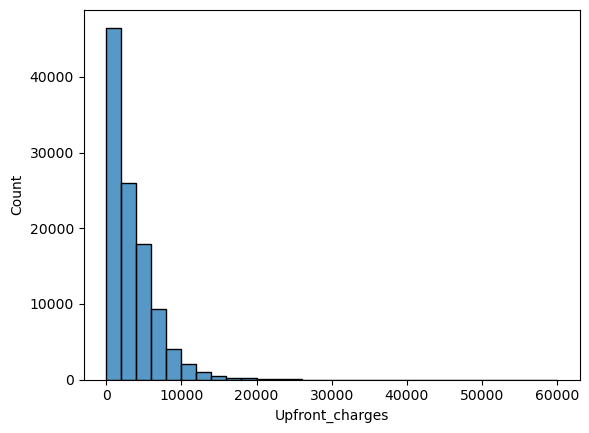

In [44]:
sns.histplot(data=df,x='Upfront_charges',bins=30)

Based on the skewness of Upfront_charges, I will fill missing values with the median since it will be less affect by extreme outliers.

In [45]:
# Replace missing values in Upfront_charges with the median value
df['Upfront_charges'].fillna(df['Upfront_charges'].median(), inplace=True)

For income, I'll look at trying to group by age to see if there is significant difference between the groups which may be better to fill missing data based on. 

In [46]:
df.groupby('age')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
25-34,17708.0,6557.514118,4958.419859,0.0,3960.0,5760.0,8040.0,235980.0
35-44,30489.0,7704.158221,5492.383471,0.0,4620.0,6720.0,9360.0,189360.0
45-54,32401.0,7975.624209,8276.904163,0.0,4320.0,6540.0,9600.0,578580.0
55-64,30663.0,6902.371588,6668.106983,0.0,3600.0,5520.0,8400.0,377220.0
65-74,19230.0,5405.597504,5422.572281,0.0,2880.0,4260.0,6420.0,312000.0
<25,1266.0,4973.270142,7542.530932,0.0,2520.0,3600.0,5625.0,198060.0
>74,6599.0,4739.909077,4535.692219,0.0,2520.0,3660.0,5580.0,136680.0


In [47]:
# Fill missing values in income based on the median income of each age
df['income'] = df['income'].fillna(df.groupby('age')['income'].transform('median'))

For missing property values, I will assume the loan amount will help get a better estimate to fill missing values.

In [48]:
# Fill missing property_values based on the median property value of each loan amount
df['property_value'] = df.groupby('loan_amount')['property_value'].transform(lambda x: x.fillna(x.median()))

Some columns can be dropped because they will not be needed

In [49]:
columns_to_drop = ['year','loan_limit','LTV','Interest_rate_spread','credit_type','co-applicant_credit_type']
df = df.drop(columns=columns_to_drop)

In [50]:
# Fill missing values in debt to income ratio based on the median income
df['dtir1'] = df['dtir1'].fillna(df.groupby('income')['dtir1'].transform('median'))

In [51]:
# Calculate the percentage of missing data
percent_nan = percent_missing(df)

# Sort the missing percentages in descending order
percent_nan_sorted = percent_nan.sort_values(ascending=False)

# Print all sorted values
print(percent_nan_sorted)

dtir1             0.032592
property_value    0.004753
dtype: float64


In [52]:
# Drop small amount of remaining NA values
df = df.dropna(subset=['property_value','dtir1'])

Categorical variables and string values will need to be changed to dummy variables to get them a numeric value to be able to model.

In [53]:
# Convert all categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

Features need to be evaluated for potential collinearity issues before modeling.

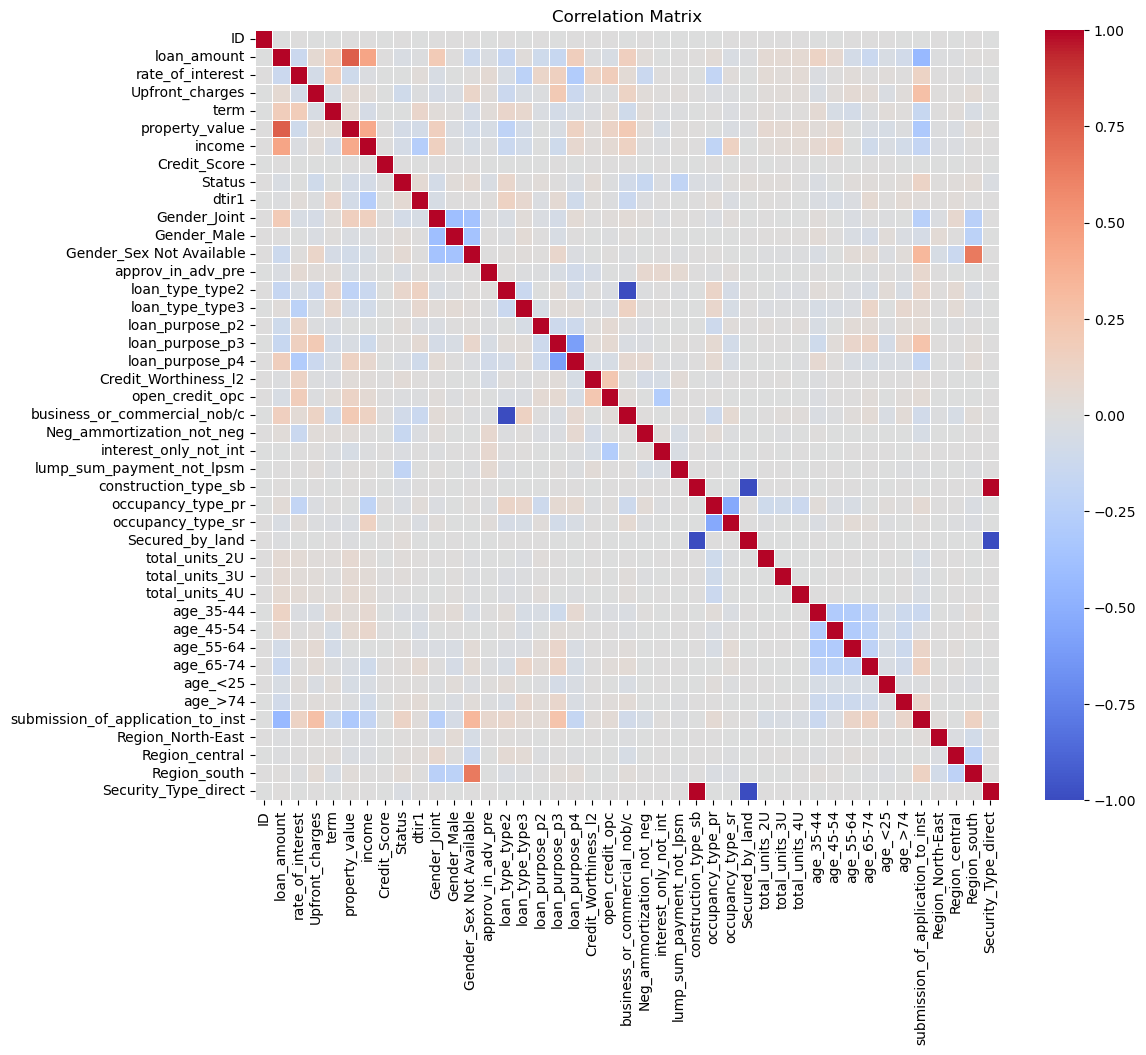

In [54]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Analysis of the correlation matrix revealed some moderately correlated features, which raises concerns about multicollinearity. To further investigate, I will calculate the Variance Inflation Factor (VIF) for each feature, identifying potential issues with variables. High VIF values can lead to unreliable coefficient estimates in linear models, affecting their predictive power. To mitigate this, I will drop variables with excessive multicollinearity, which will help stabilize the model coefficients and improve its interpretability.

In [55]:
# Convert all boolean columns to integers
X = df
X = X.astype(int)

X_with_constant = add_constant(X)

# Calculate VIF for each feature in the dataset
vif = pd.DataFrame()
vif['Variable'] = X_with_constant.columns
vif['VIF'] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

# Display the VIF values
print(vif)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                             Variable       VIF
0                               const  0.000000
1                                  ID  1.000336
2                         loan_amount  3.395121
3                    rate_of_interest  1.574154
4                     Upfront_charges  1.275243
5                                term  1.183869
6                      property_value  2.851596
7                              income  1.527050
8                        Credit_Score  1.000273
9                              Status  1.328290
10                              dtir1  1.138451
11                       Gender_Joint  1.926766
12                        Gender_Male  1.877489
13           Gender_Sex Not Available  2.698735
14                  approv_in_adv_pre  1.061756
15                    loan_type_type2       inf
16                    loan_type_type3  1.194211
17                    loan_purpose_p2  1.143975
18                    loan_purpose_p3  2.031497
19                    loan_purpose_p4  1

A couple of the VIF factors came back as inf, which may indicate direct relationships with other factors.  I will drop these columns and re-calculate the VIF values.

In [56]:
X = X.drop(['loan_type_type2', 'business_or_commercial_nob/c', 'construction_type_sb', 'Secured_by_land'], axis=1, errors='ignore')

In [57]:
# Add a constant to the dataset for VIF calculation
X_with_constant = add_constant(X)

# Calculate VIF for each feature in the dataset
vif = pd.DataFrame()
vif['Variable'] = X_with_constant.columns
vif['VIF'] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

# Display the VIF values
print(vif)

                             Variable          VIF
0                               const  4748.445616
1                                  ID     1.000329
2                         loan_amount     3.394993
3                    rate_of_interest     1.547302
4                     Upfront_charges     1.241334
5                                term     1.160333
6                      property_value     2.811376
7                              income     1.526975
8                        Credit_Score     1.000264
9                              Status     1.314546
10                              dtir1     1.120928
11                       Gender_Joint     1.926242
12                        Gender_Male     1.877473
13           Gender_Sex Not Available     2.698669
14                  approv_in_adv_pre     1.061755
15                    loan_type_type3     1.143986
16                    loan_purpose_p2     1.143670
17                    loan_purpose_p3     2.028478
18                    loan_purp

Now it's time to set up and run the models.  I will try Logistic Regression and Random Forest Classifier and compare the results.  By utilizing both Logistic Regression and Random Forest Classifier, I aimed to leverage the strengths of each model. Logistic Regression offers interpretability and efficiency, while Random Forest provides robustness and the ability to capture complex relationships. This dual approach allows for a comprehensive analysis of the factors influencing loan defaults and facilitates the identification of the most effective predictive strategies.

# Modeling

In [58]:
# Define target variable and features
X = df.drop('Status', axis=1) 
y = df['Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit the scaler on the training data
X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same scaler

In [59]:
# Create a logistic regression model
log_model = LogisticRegression(max_iter=1000)

# Train the model using the scaled data
log_model.fit(X_train_scaled, y_train)

# Make predictions using the scaled test data
y_pred_log = log_model.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

Logistic Regression Results:
[[21552   587]
 [ 5926  1380]]
              precision    recall  f1-score   support

           0       0.78      0.97      0.87     22139
           1       0.70      0.19      0.30      7306

    accuracy                           0.78     29445
   macro avg       0.74      0.58      0.58     29445
weighted avg       0.76      0.78      0.73     29445

Accuracy: 0.7788079470198676


The intitial model did fairly well on overall accuracy but didn't do well on the f1 score for class 1.  This may have been due to a class imbalance in the training set.  To account for this and to try and improve the model, I'll trying running a grid search with different C values and class weights which will help with that distribution and hopefully the f1-score.

In [60]:
# Define the logistic regression model
log_model = LogisticRegression(max_iter=1000)

# Define the parameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'class_weight': [None, 'balanced', {0: 1, 1: 10},{0: 1, 1: 20}, {0: 1, 1: 30}],  
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid, cv=5, scoring='f1', verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model from GridSearch
best_log_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_best_log = best_log_model.predict(X_test_scaled)

# Evaluate the model
print("Logistic Regression Results with Grid Search:")
print(confusion_matrix(y_test, y_pred_best_log))
print(classification_report(y_test, y_pred_best_log))
print("Accuracy:", accuracy_score(y_test, y_pred_best_log))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 0.01, 'class_weight': 'balanced'}
Logistic Regression Results with Grid Search:
[[15185  6954]
 [ 2516  4790]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.76     22139
           1       0.41      0.66      0.50      7306

    accuracy                           0.68     29445
   macro avg       0.63      0.67      0.63     29445
weighted avg       0.75      0.68      0.70     29445

Accuracy: 0.6783834267277976


Logistic Regression initially achieved an accuracy of 77.8%, but it struggled to identify borrowers likely to default (Class 1), as evidenced by a low F1-score of 0.30. This could be attributed to a class imbalance in the dataset, where the number of non-default cases significantly outweighed the default cases. To address this, I applied class weights to give more importance to the minority class during model training. By using a balanced class weight in GridSearchCV, I improved the recall for Class 1 from 0.19 to 0.66, indicating a better sensitivity to potential defaulters.

In [61]:
coeff = best_log_model.coef_[0]
feature_names = X.columns 

# Create a DataFrame to hold the coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeff})

# Sort by the absolute value of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df[['Feature', 'Coefficient']])

                              Feature  Coefficient
3                     Upfront_charges    -0.537711
1                         loan_amount     0.482245
37  submission_of_application_to_inst     0.453946
23          lump_sum_payment_not_lpsm    -0.390302
21          Neg_ammortization_not_neg    -0.308218
5                      property_value    -0.299393
6                              income    -0.268781
2                    rate_of_interest    -0.206660
25                  occupancy_type_pr    -0.190415
9                        Gender_Joint    -0.098500
33                          age_55-64     0.090039
34                          age_65-74     0.088676
17                    loan_purpose_p4    -0.083869
36                            age_>74     0.080573
22              interest_only_not_int    -0.070721
14                    loan_type_type3    -0.069414
18               Credit_Worthiness_l2     0.066234
40                       Region_south     0.065663
28                     total_un

It looks like some of the major factors impacting default are the loan amount and if the loan was submitted to an institution.  I would have to check with a domain expert to see if these results make sense and further refine the model and features to get better results.  

I will also try a Random Forest Classifier model to see if it does any better.

In [62]:
# Instantiate the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model using training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions using the test data
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
print("Random Forest Classifier Results:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Classifier Results:
[[22139     0]
 [    0  7306]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22139
           1       1.00      1.00      1.00      7306

    accuracy                           1.00     29445
   macro avg       1.00      1.00      1.00     29445
weighted avg       1.00      1.00      1.00     29445

Accuracy: 1.0


In [63]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Instantiate the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the Random Forest model using PCA-transformed training data
rf_model.fit(X_train_pca, y_train)

# Make predictions using the PCA-transformed test data
y_pred_rf_pca = rf_model.predict(X_test_pca)

# Evaluate the Random Forest model
print("Random Forest Classifier Results with PCA:")
print(confusion_matrix(y_test, y_pred_rf_pca))
print(classification_report(y_test, y_pred_rf_pca))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_pca))

Random Forest Classifier Results with PCA:
[[21481   658]
 [ 3550  3756]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     22139
           1       0.85      0.51      0.64      7306

    accuracy                           0.86     29445
   macro avg       0.85      0.74      0.78     29445
weighted avg       0.86      0.86      0.84     29445

Accuracy: 0.8570894888775683


PCA transformed the dataset into a lower-dimensional space, making it easier for the Random Forest Classifier to focus on relevant patterns. As a result, the accuracy decreased slightly to 85.7%, but the model’s generalizability and F1-score for identifying defaulters improved significantly. This demonstrates the effectiveness of dimensionality reduction techniques in managing high-dimensional data and reducing noise in the dataset.

In [64]:
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'class_weight': ['balanced', None]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train_pca, y_train)

# Get the best model from grid search
best_rf = grid_search.best_estimator_

# Fit the best Random Forest model
best_rf.fit(X_train_pca, y_train)

# Make predictions using the best model
y_pred_best_rf = best_rf.predict(X_test_pca)  

# Evaluate the best model's performance
print("Best Random Forest Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Random Forest Model:
Accuracy: 0.8591611479028698
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     22139
           1       0.83      0.55      0.66      7306

    accuracy                           0.86     29445
   macro avg       0.85      0.75      0.78     29445
weighted avg       0.86      0.86      0.85     29445



To further enhance model performance, I performed hyperparameter tuning using GridSearchCV for both Logistic Regression and the Random Forest Classifier. By systematically testing different values of hyperparameters, such as C for Logistic Regression and n_estimators and max_depth for Random Forest, I was able to identify the optimal settings that maximized the model’s predictive accuracy. The best-performing Random Forest model achieved an accuracy of 85.9% and a balanced F1-score, indicating that the tuning process was successful in optimizing model performance without compromising recall for the minority class.

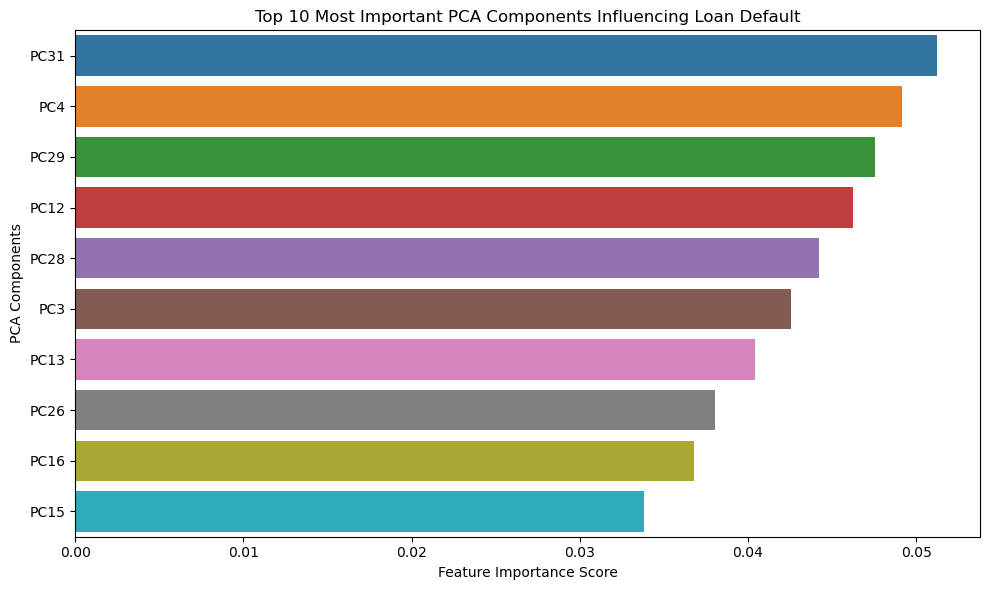

In [66]:
# Generate the names for the PCA components
pca_feature_names = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]

# Create a DataFrame for feature importances using PCA component names
importance_df = pd.DataFrame({'Feature': pca_feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important PCA components
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Important PCA Components Influencing Loan Default')
plt.xlabel('Feature Importance Score')
plt.ylabel('PCA Components')
plt.tight_layout()
plt.show()

In [72]:
# Show top features in top PC
top_pc = 'PC31' 
most_influential_features = loadings_df.loc[top_pc].abs().sort_values(ascending=False)
print(f"Top 10 most influential features for {top_pc}:\n")
print(most_influential_features.head(10))

Top 10 most influential features for PC31:

income                               0.452104
open_credit_opc                      0.450560
rate_of_interest                     0.351038
submission_of_application_to_inst    0.338988
interest_only_not_int                0.316315
dtir1                                0.257880
Neg_ammortization_not_neg            0.198534
occupancy_type_sr                    0.196084
loan_type_type3                      0.146258
term                                 0.103937
Name: PC31, dtype: float64


# Conclusions

The combination of Logistic Regression and Random Forest provided a comprehensive approach to understanding loan default patterns. While Logistic Regression offered interpretability and insight into key factors influencing defaults, the Random Forest model provided higher accuracy and robustness against overfitting, especially after dimensionality reduction using PCA. The iterative approach of data cleaning, feature engineering, model comparison, and hyperparameter tuning resulted in a well-validated model capable of making reliable predictions on unseen data.

While the Random Forest model ended up performing better overall, one of the challenges is the interpretability is more difficult.  We can pull out some of the most influential factors from the primary compenents to get a sense of the major drivers.  Primary Component 31 has the largest loading factor in the model and the main factors driving that component were income, open_credit_opc, and rate of interest.

One of the challenges in this model was the large number of features and potential collinearity problems.  In the future the assistance of domain expert could help with potential transformation and/or reduction of those features based on their expertise.  There was also a large class imbalance in the data so different techniques like SMOTE and other models like XGBoost could be used but I would have to look further into how to apply these techniques.